## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ve_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos      TRM  Precio Interno    PI    MHI   FNI    SI
0   2020-01-01    1.289946  3277.14        975000.0  0.00   0.00  0.00  0.00
1   2020-01-02    0.735046  3277.14        945000.0  0.00   0.00  0.00  0.00
2   2020-01-03    0.591834  3258.84        940000.0  0.00   0.00  0.00  0.00
3   2020-01-04    1.367154  3262.05        930000.0  0.00   0.00  0.00  0.00
4   2020-01-05    1.505321  3262.05        920000.0  0.00   0.00  0.00  0.00
..         ...         ...      ...             ...   ...    ...   ...   ...
913 2022-07-02    0.778572  4198.77       2270000.0  4.66  25.71  0.19 -3.56
914 2022-07-03    0.819483  4198.77       2270000.0  0.42   7.76  0.00 -3.67
915 2022-07-04    0.843804  4198.77       2270000.0  0.54  31.37  0.27 -5.85
916 2022-07-05    0.850985  4198.77       2280000.0  0.48  38.21  0.12 -4.97
917 2022-07-06    0.840437  4259.86       2302000.0  0.52  27.93  0.00 -7.87

[918 rows x 8 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [11]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(273, 1)
(273, 27)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23539470791619352
MAE is : 0.3466723982892895
RMSE is : 0.48517492506949855
MAPE is : 16.873197513747915
Evaluation metric results:
MSE is : 12.647220272049427
MAE is : 3.3362393717275203
RMSE is : 3.5562930520486393
MAPE is : 191.66730745414384
(273, 1)
(273, 27)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23333307733201328
MAE is : 0.3462502653326612
RMSE is : 0.48304562655303407
MAPE is : 16.855259471502375
Evaluation metric results:
MSE is : 10.295844104627667
MAE is : 3.0010925374245443
RMSE is : 3.2087137772988834
MAPE is : 173.61258654967534
(273, 1)
(273, 27)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22465365127915668
MAE is : 0.3393685998632158
RMSE is : 0.4739764248136786
MAPE is : 16.604418423442777
Evaluation metric results:
MSE is : 11.551628793296894
MAE is : 3.191786723431593
RMSE is : 3.3987687172411265
MAPE is : 183.89063498114993
(273, 1)
(273, 27)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22738536016106878
MAE is : 0.3448797936113442
RMSE is : 0.476849410360408
MAPE is : 16.875397026978238
Evaluation metric results:
MSE is : 10.77322077036077
MAE is : 3.0699973248956107
RMSE is : 3.2822584862196287
MAPE is : 177.45901739699238
(273, 1)
(273, 27)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22740106590850848
MAE is : 0.34346831910173
RMSE is : 0.47686587832272975
MAPE is : 16.765292074823932
Evaluation metric results:
MSE is : 11.738051469308404
MAE is : 3.2178803111999947
RMSE is : 3.426083984567279
MAPE is : 185.12086313154964
(271, 1)
(271, 41)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.24184455878618505
MAE is : 0.3474419981112424
RMSE is : 0.491776940071599
MAPE is : 16.839026720489198
Evaluation metric results:
MSE is : 15.7485252423802
MAE is : 3.728678262648369
RMSE is : 3.968441160251743
MAPE is : 212.2409255712995
(271, 1)
(271, 41)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22558326842261903
MAE is : 0.33741950617242167
RMSE is : 0.4749560699923931
MAPE is : 16.46166619716839
Evaluation metric results:
MSE is : 12.864844184309733
MAE is : 3.3534711648164173
RMSE is : 3.586759566002401
MAPE is : 193.00670204164547
(271, 1)
(271, 41)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21510312641033943
MAE is : 0.33824295400586696
RMSE is : 0.463792115511184
MAPE is : 16.723415021461822
Evaluation metric results:
MSE is : 15.840046724244255
MAE is : 3.747699852041952
RMSE is : 3.979955618376197
MAPE is : 213.795655672948
(271, 1)
(271, 41)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21911745354350196
MAE is : 0.3386620635905429
RMSE is : 0.468099832881301
MAPE is : 16.653739921007208
Evaluation metric results:
MSE is : 14.271155692926424
MAE is : 3.5494053262366387
RMSE is : 3.7777183183671097
MAPE is : 203.3126996070726
(271, 1)
(271, 41)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22198709608097916
MAE is : 0.3417359563211445
RMSE is : 0.4711550658551589
MAPE is : 16.70464121681133
Evaluation metric results:
MSE is : 15.405914740346974
MAE is : 3.6941936287243307
RMSE is : 3.9250369094247985
MAPE is : 210.8278876313269
(269, 1)
(269, 55)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2465246385573155
MAE is : 0.3553477463537467
RMSE is : 0.4965124757317942
MAPE is : 17.41080014519359
Evaluation metric results:
MSE is : 11.42189839000359
MAE is : 3.1423356616293283
RMSE is : 3.3796299190893064
MAPE is : 181.51634515858697


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(269, 1)
(269, 55)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21617247807240605
MAE is : 0.3429341791666251
RMSE is : 0.46494352137910905
MAPE is : 16.976023241957307
Evaluation metric results:
MSE is : 17.86862243532901
MAE is : 3.9935633913121027
RMSE is : 4.227129337426169
MAPE is : 226.57993668432573
(269, 1)
(269, 55)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21336567824377511
MAE is : 0.340361283742001
RMSE is : 0.4619152284172661
MAPE is : 16.79013844064035
Evaluation metric results:
MSE is : 15.493981899895411
MAE is : 3.7022205873440472
RMSE is : 3.9362395633263243
MAPE is : 211.51542266149445
(269, 1)
(269, 55)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21817840407330982
MAE is : 0.34173880837194115
RMSE is : 0.46709571189779703
MAPE is : 16.90520493475722
Evaluation metric results:
MSE is : 15.523233297031156
MAE is : 3.7156595045759326
RMSE is : 3.939953463815424
MAPE is : 212.0054807334113
(269, 1)
(269, 55)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21907956497459163
MAE is : 0.3410868135182572
RMSE is : 0.46805936052448693
MAPE is : 16.747340434845544
Evaluation metric results:
MSE is : 14.062955372438259
MAE is : 3.522340208876524
RMSE is : 3.7500607158335795
MAPE is : 201.94499475350293
(268, 1)
(268, 62)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.25119309515681854
MAE is : 0.3587346181845591
RMSE is : 0.5011916750673524
MAPE is : 17.56154317046517
Evaluation metric results:
MSE is : 6.20327470607377
MAE is : 2.283404970755433
RMSE is : 2.4906374095949353
MAPE is : 135.20936689880037
(268, 1)
(268, 62)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2394607941651622
MAE is : 0.35278410717047615
RMSE is : 0.4893473144558599
MAPE is : 17.31927647276276
Evaluation metric results:
MSE is : 9.184535215903406
MAE is : 2.8164402395695047
RMSE is : 3.0305998112425545
MAPE is : 164.4900925092772
(268, 1)
(268, 62)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2227219811006376
MAE is : 0.3421513554614475
RMSE is : 0.47193429744047805
MAPE is : 16.81274050637623
Evaluation metric results:
MSE is : 8.697255776724715
MAE is : 2.7335455623098195
RMSE is : 2.949111014649112
MAPE is : 160.1623924317371
(268, 1)
(268, 62)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21867809153903778
MAE is : 0.3409176483873512
RMSE is : 0.4676302936498423
MAPE is : 16.876239941027897
Evaluation metric results:
MSE is : 9.987209774021387
MAE is : 2.939850901734837
RMSE is : 3.1602547008146966
MAPE is : 171.35582431984614
(268, 1)
(268, 62)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22711359415717008
MAE is : 0.3427215865260195
RMSE is : 0.4765643651776432
MAPE is : 16.857675870184135
Evaluation metric results:
MSE is : 8.307136580232818
MAE is : 2.666973797145257
RMSE is : 2.882210363632887
MAPE is : 156.7003899487478
(266, 1)
(266, 76)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2287602017477261
MAE is : 0.34454431914257694
RMSE is : 0.478288826701739
MAPE is : 16.938807235697727
Evaluation metric results:
MSE is : 8.28280793905193
MAE is : 2.6618925132544344
RMSE is : 2.8779867857674275
MAPE is : 156.41472554003605
(266, 1)
(266, 76)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.22440627383043216
MAE is : 0.3410449428868199
RMSE is : 0.4737153932800075
MAPE is : 16.607871345853262
Evaluation metric results:
MSE is : 10.399650166065975
MAE is : 3.0156469711585263
RMSE is : 3.2248488594143407
MAPE is : 175.90323024780943
(266, 1)
(266, 76)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.220256990598393
MAE is : 0.3380332544907008
RMSE is : 0.4693154489236349
MAPE is : 16.527961479970035
Evaluation metric results:
MSE is : 6.915169210405795
MAE is : 2.4265470159243376
RMSE is : 2.6296709319619813
MAPE is : 143.7141074620896
(266, 1)
(266, 76)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21653725725099407
MAE is : 0.3354106370850981
RMSE is : 0.46533563935184896
MAPE is : 16.420949775113776
Evaluation metric results:
MSE is : 9.425529326207355
MAE is : 2.8580185344223956
RMSE is : 3.0701024944140474
MAPE is : 167.31906017091083
(266, 1)
(266, 76)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.22242186192328153
MAE is : 0.3404879552818577
RMSE is : 0.47161622313410884
MAPE is : 16.67157507772843
Evaluation metric results:
MSE is : 8.397605115449378
MAE is : 2.6875811927562867
RMSE is : 2.8978621629486416
MAPE is : 158.2306080061099
(261, 1)
(261, 111)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.24194426385538753
MAE is : 0.34929178494538154
RMSE is : 0.4918783018749531
MAPE is : 16.8375843868761
Evaluation metric results:
MSE is : 10.071776252122516
MAE is : 2.94081232343562
RMSE is : 3.173606190459446
MAPE is : 170.93320411126172
(261, 1)
(261, 111)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.22993788090400522
MAE is : 0.35117561952689297
RMSE is : 0.4795183843232762
MAPE is : 17.25256914211785
Evaluation metric results:
MSE is : 8.339413718618026
MAE is : 2.6706762972180504
RMSE is : 2.887804307535056
MAPE is : 156.66534923409182
(261, 1)
(261, 111)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.22135949901997204
MAE is : 0.3387806031625074
RMSE is : 0.47048857480280226
MAPE is : 16.64817579269963
Evaluation metric results:
MSE is : 6.3158178665255225
MAE is : 2.303106121803115
RMSE is : 2.513129098658786
MAPE is : 136.26763415868513
(261, 1)
(261, 111)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2205245554233781
MAE is : 0.3404755072649971
RMSE is : 0.4696004210212956
MAPE is : 16.751311936268444
Evaluation metric results:
MSE is : 5.652626334022789
MAE is : 2.1727224853990834
RMSE is : 2.3775252541293415
MAPE is : 129.10613554942285
(261, 1)
(261, 111)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.22450909952898623
MAE is : 0.34314656472730554
RMSE is : 0.4738239119430194
MAPE is : 16.841493588524685
Evaluation metric results:
MSE is : 7.629277580496186
MAE is : 2.547108944009598
RMSE is : 2.762114693581023
MAPE is : 149.9342511776741


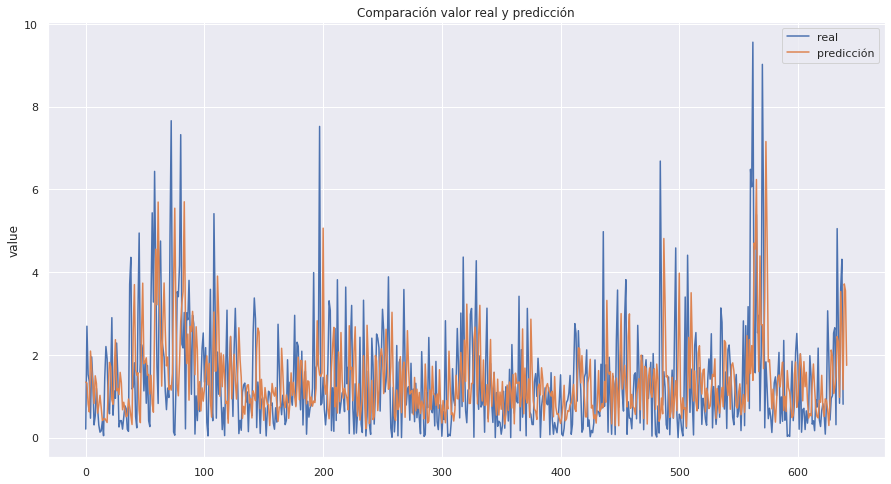

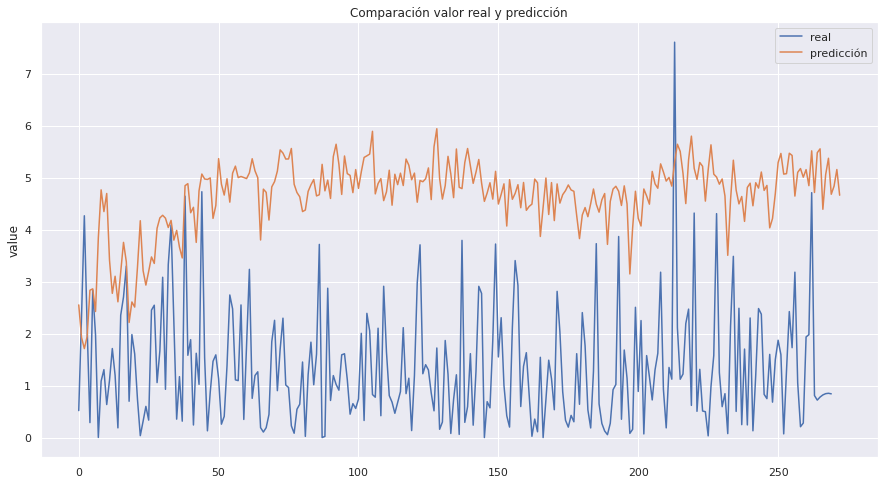

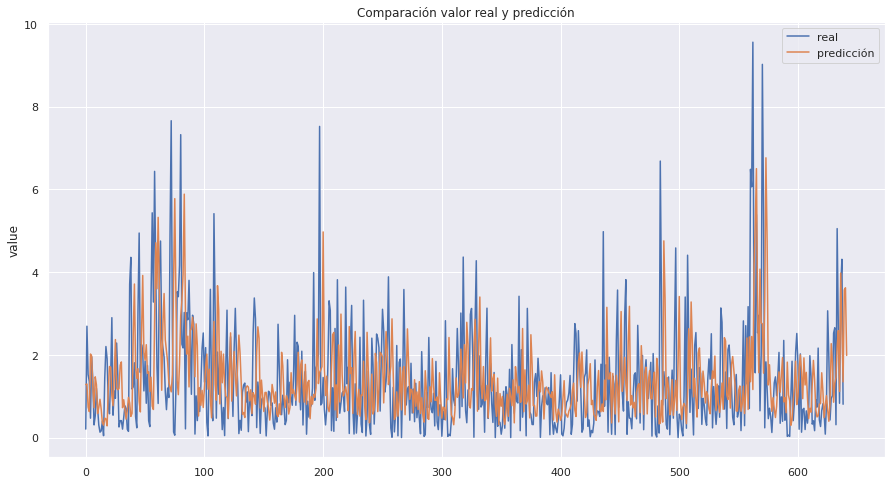

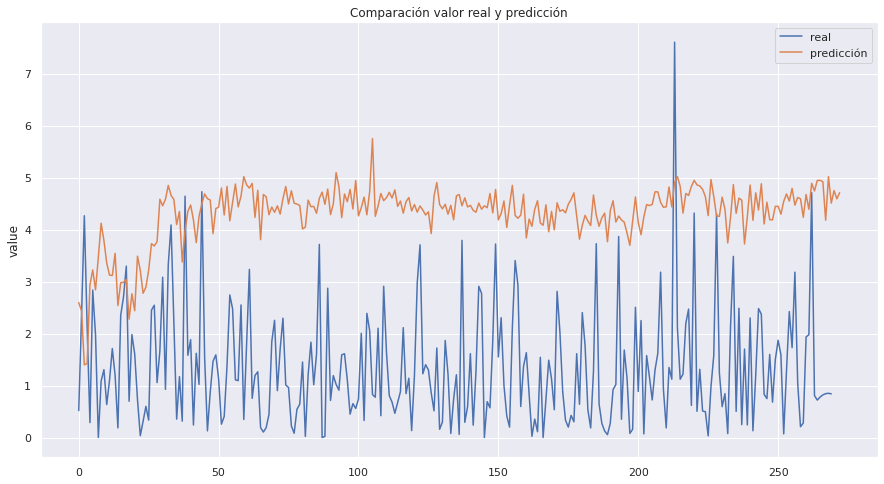

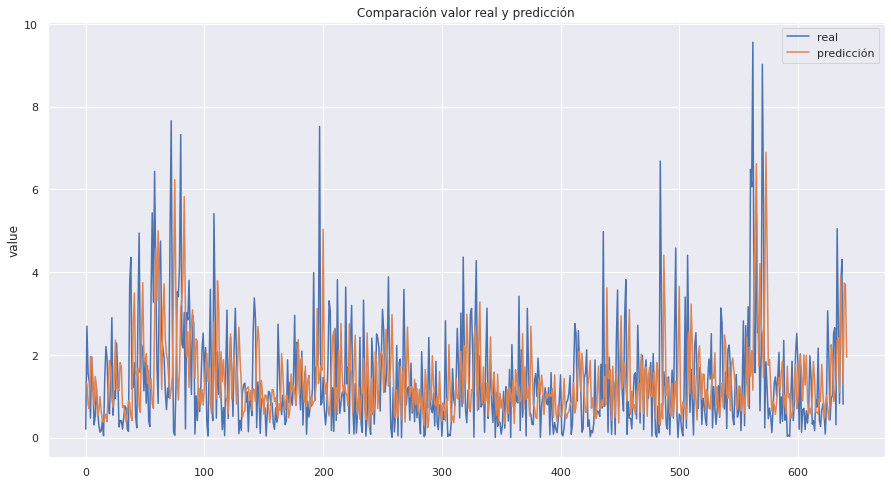

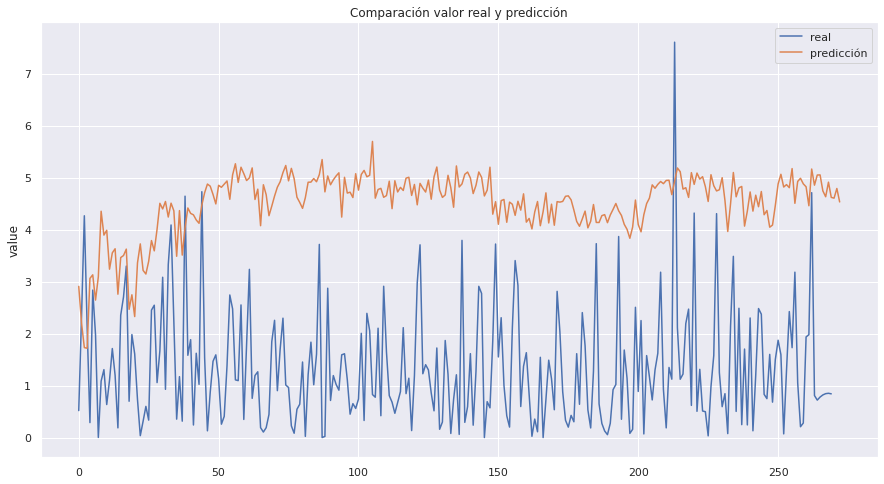

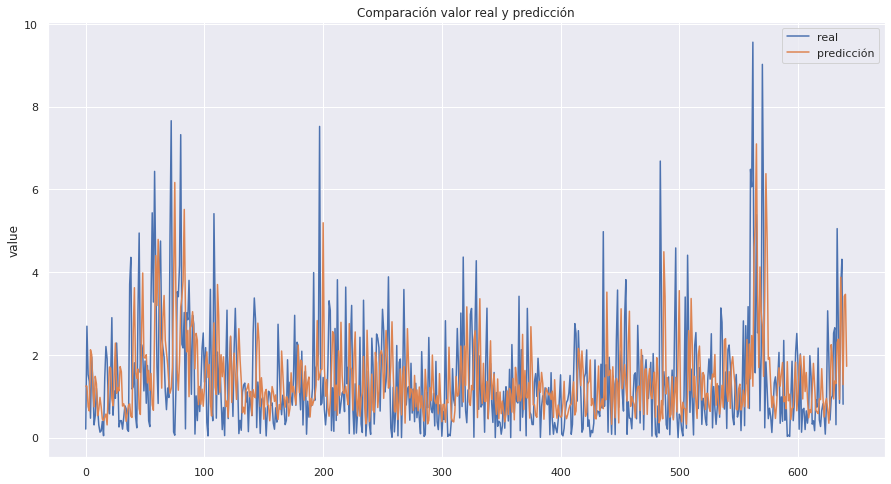

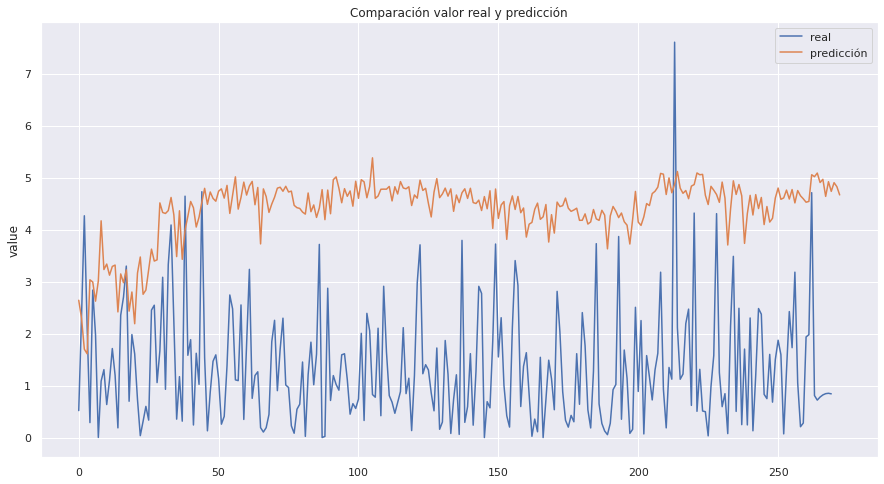

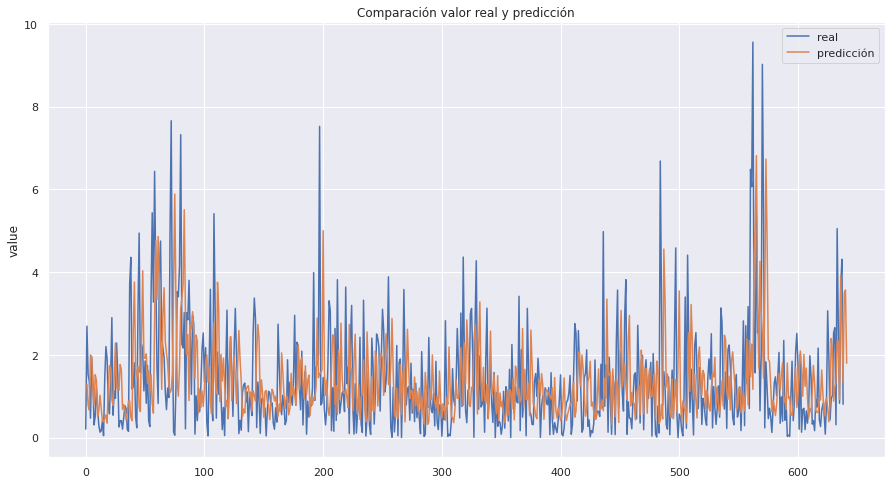

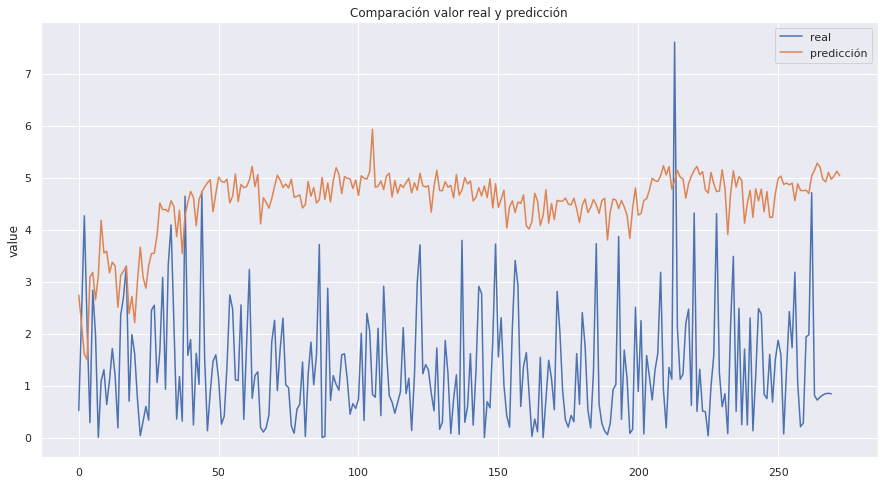

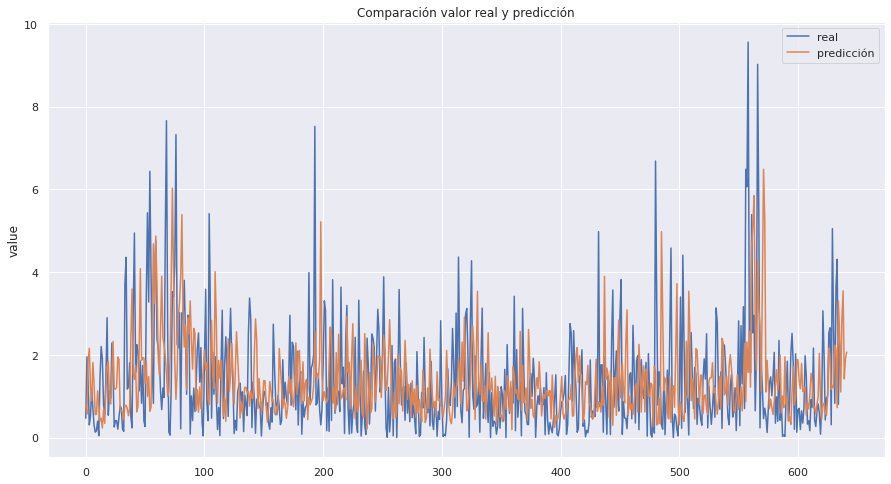

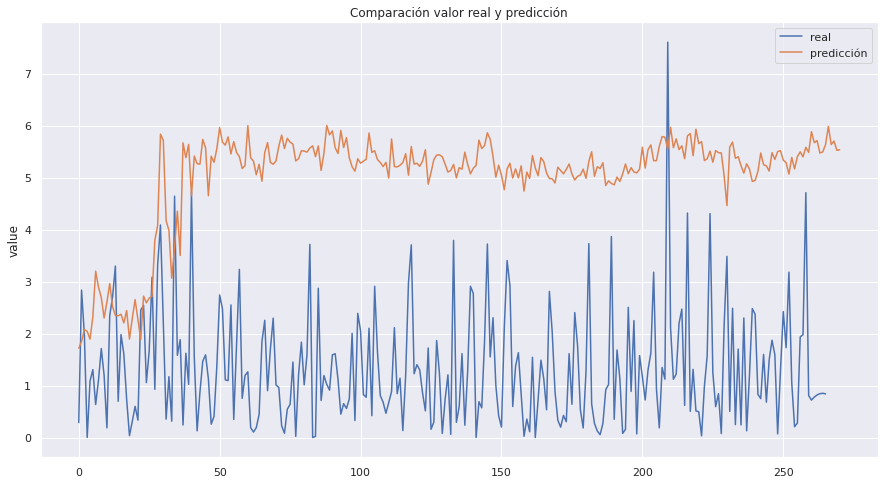

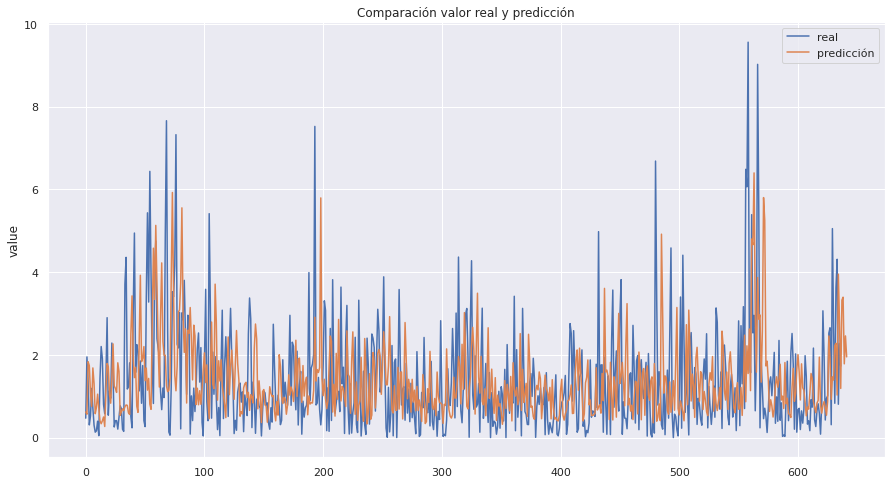

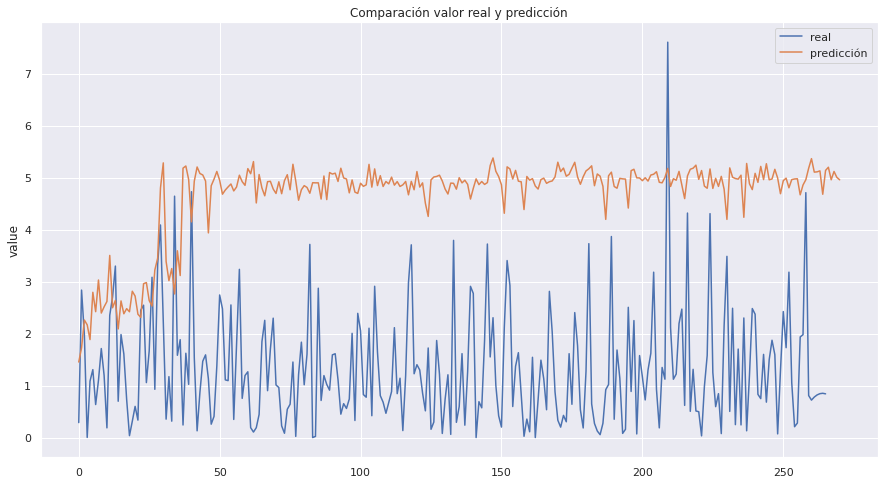

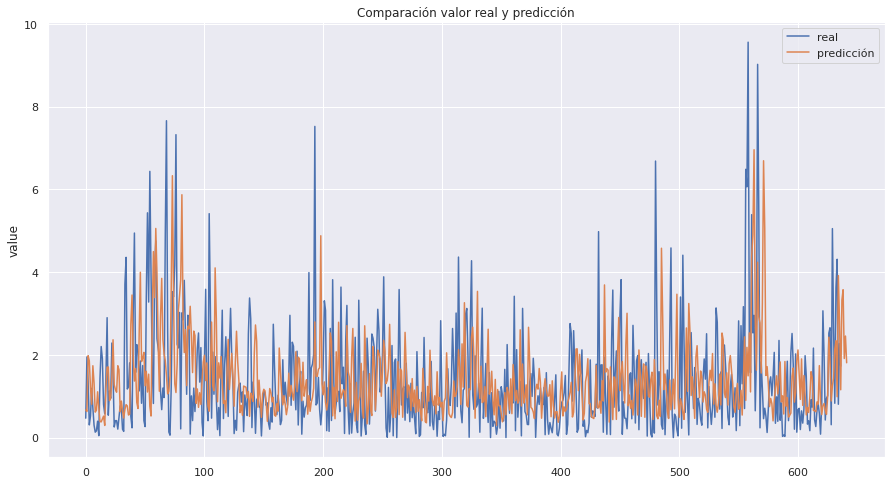

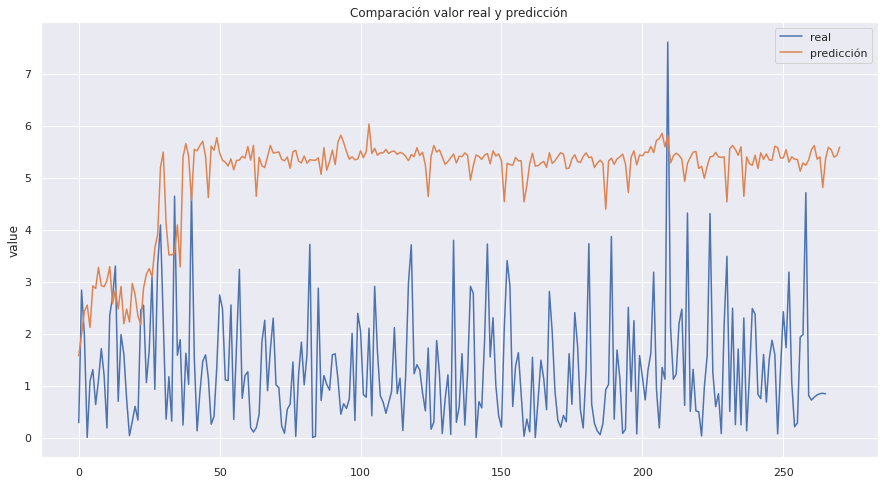

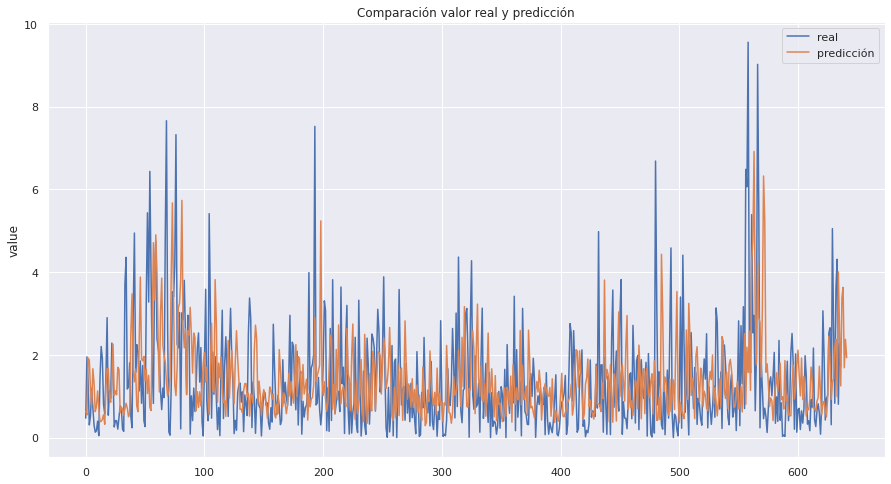

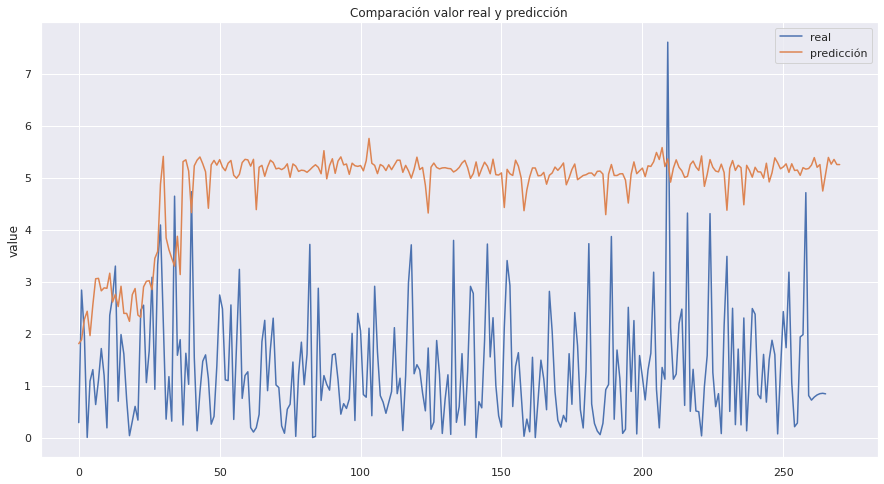

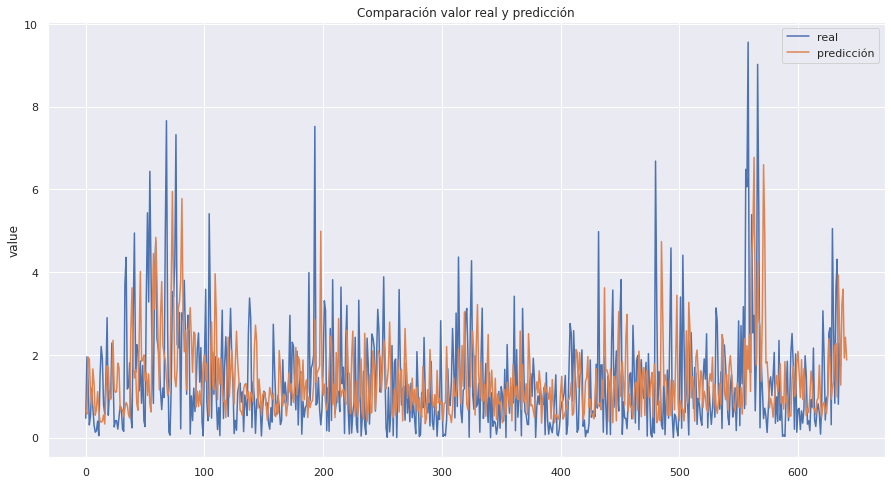

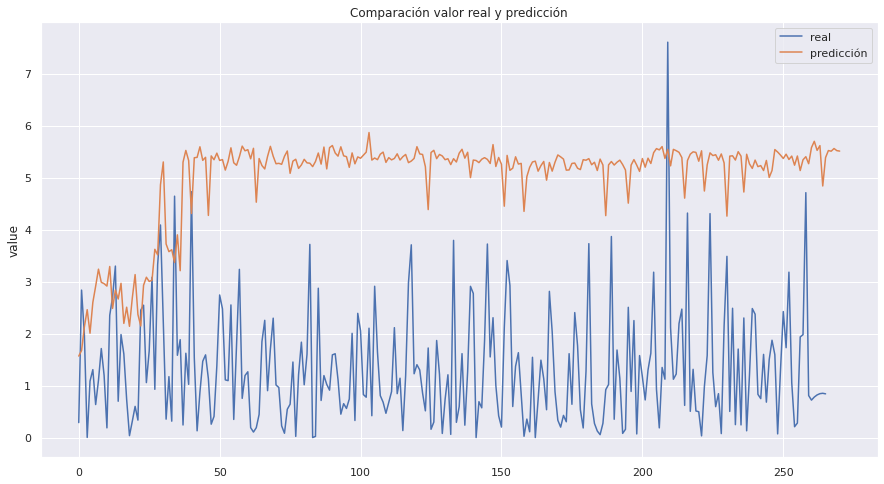

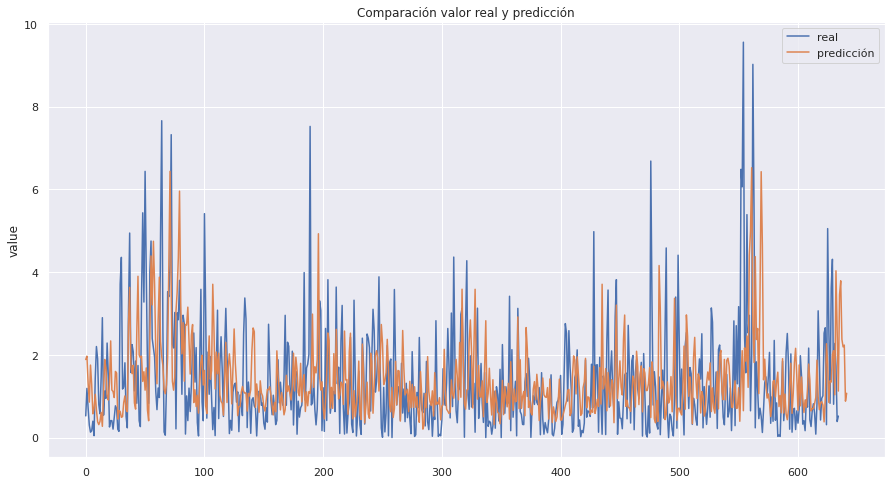

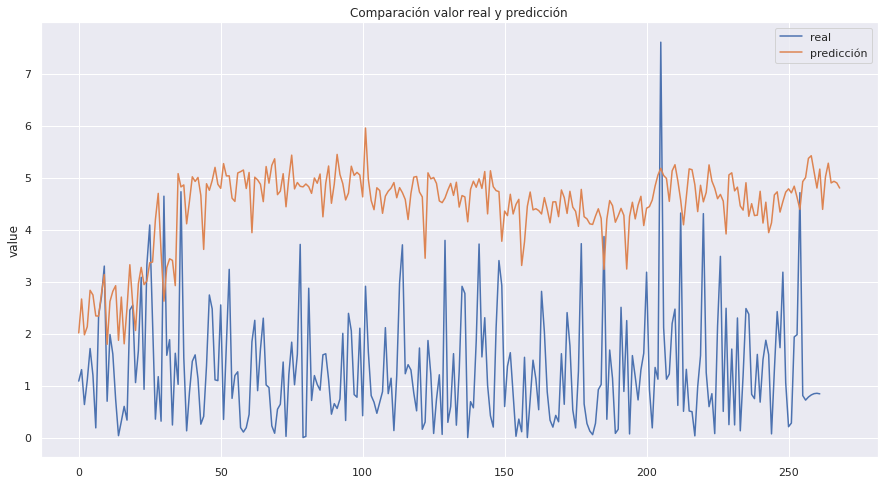

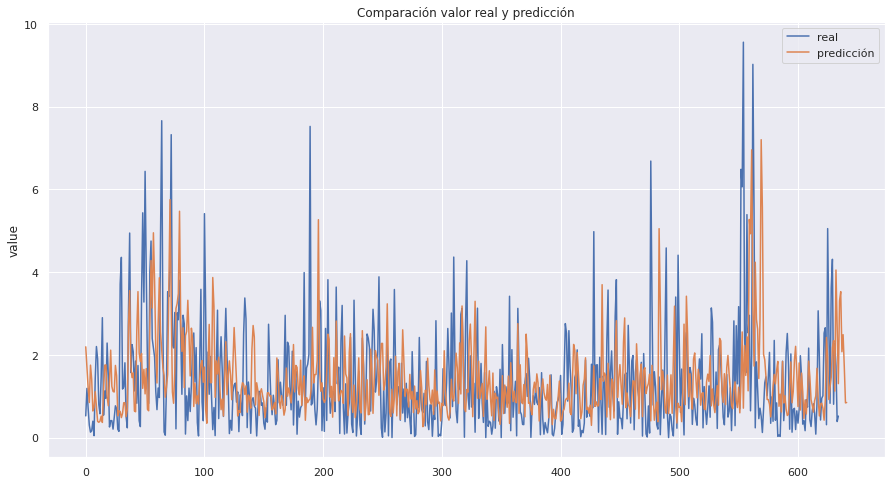

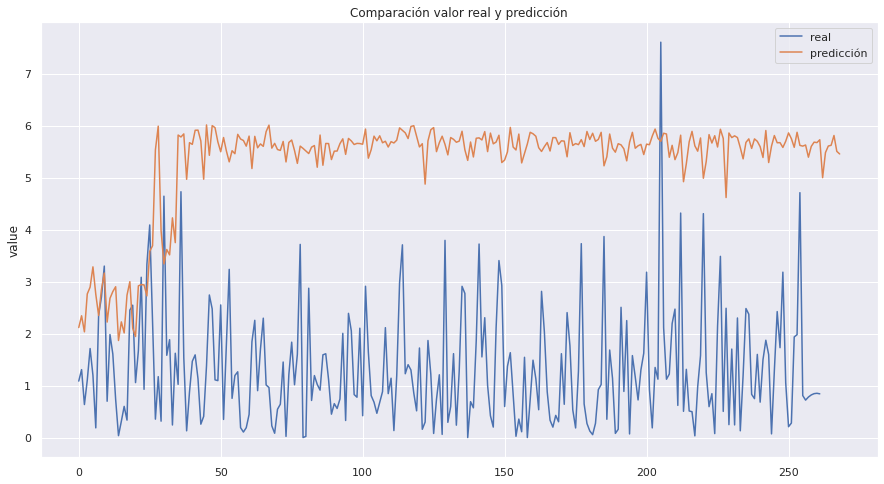

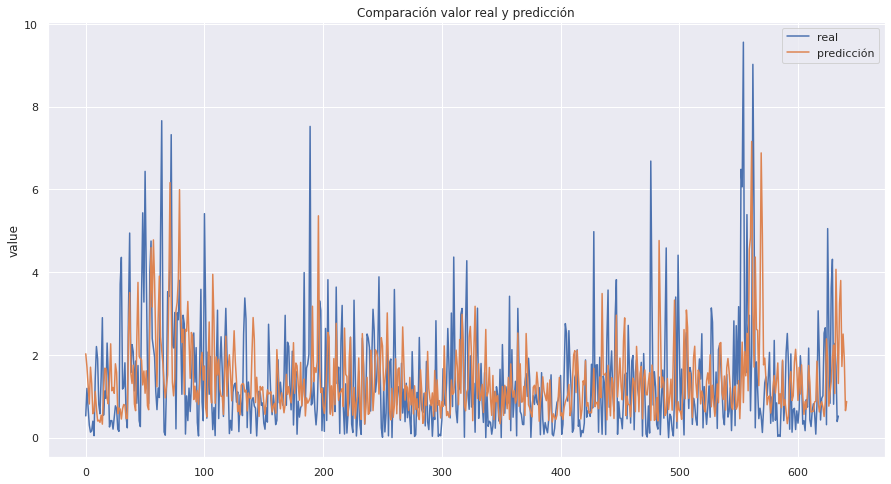

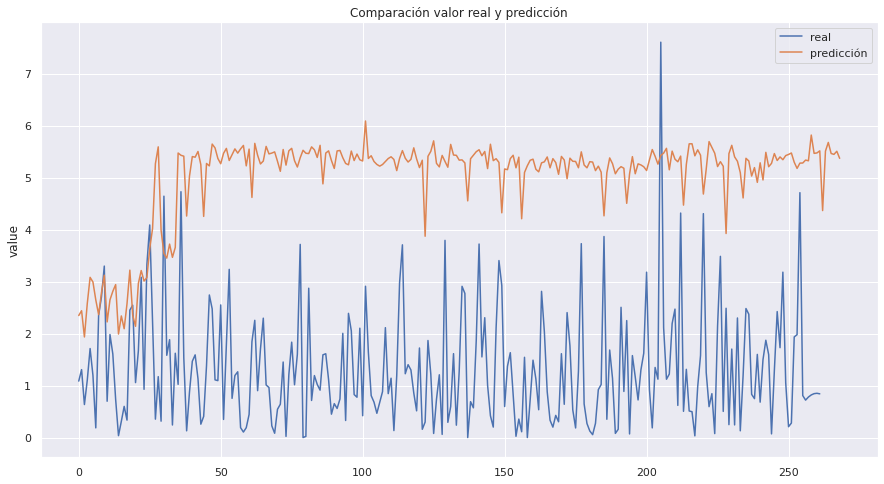

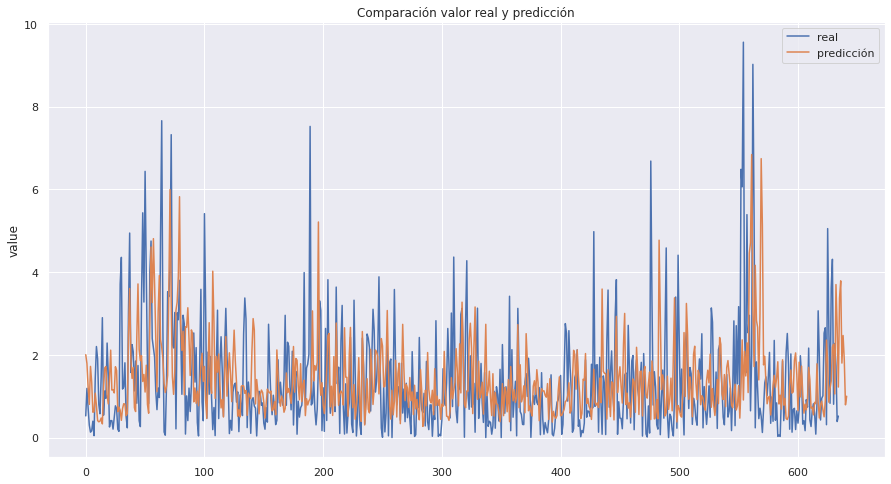

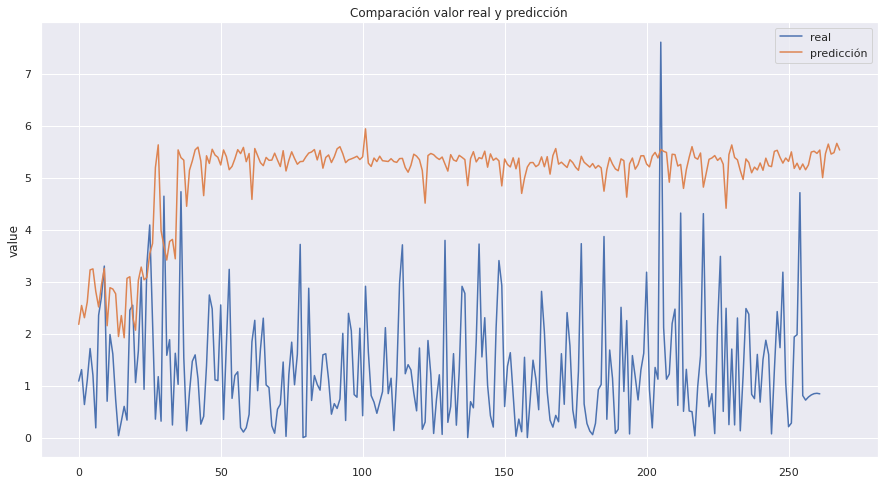

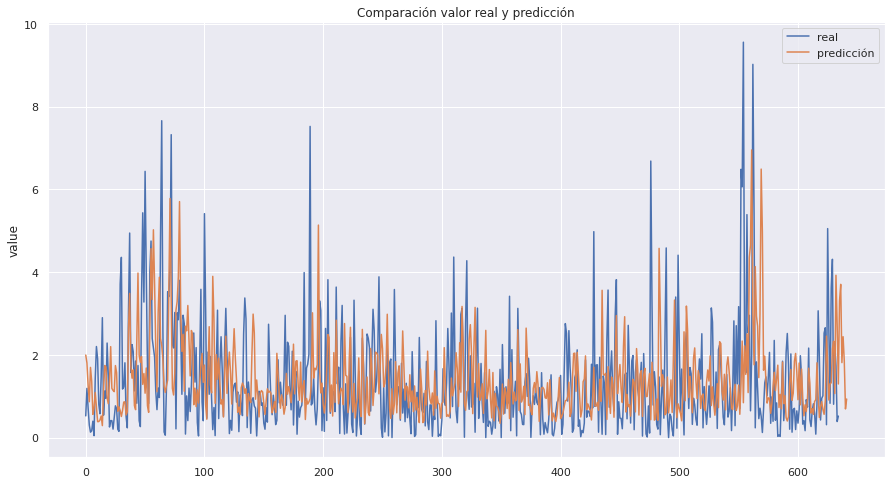

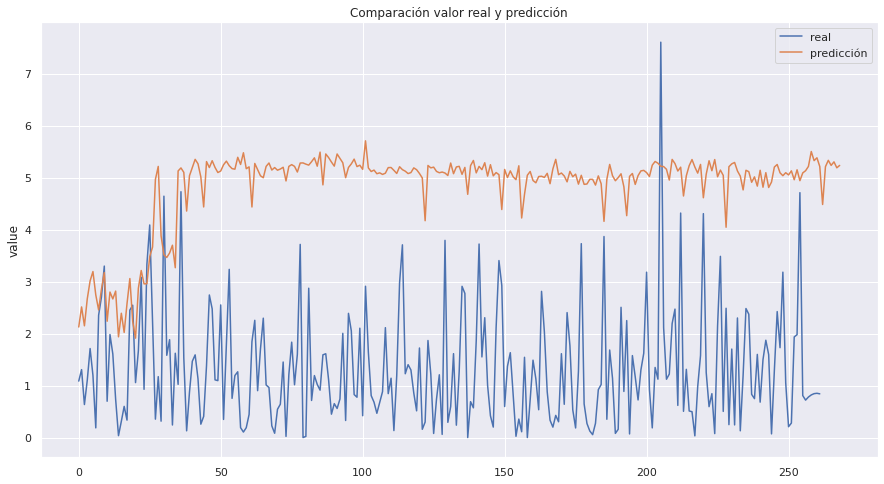

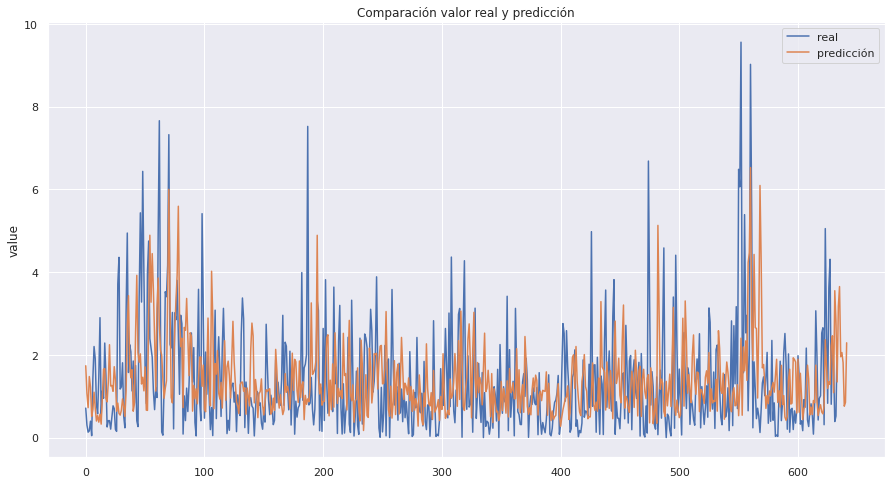

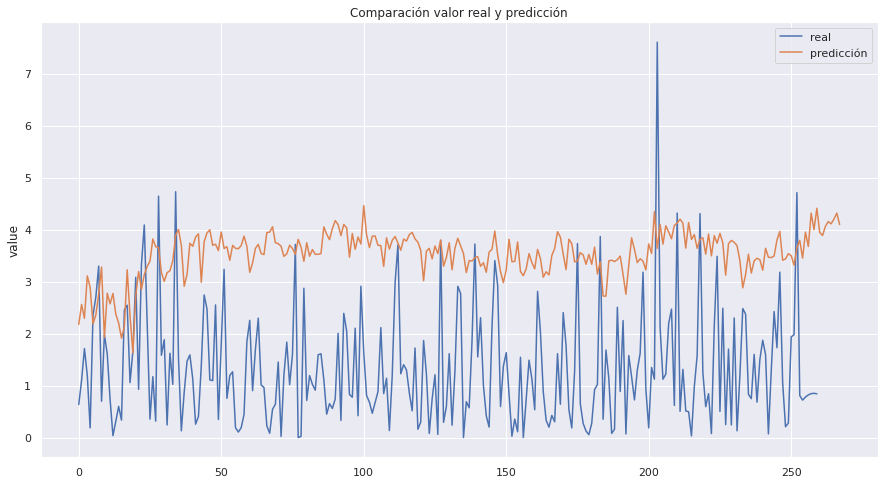

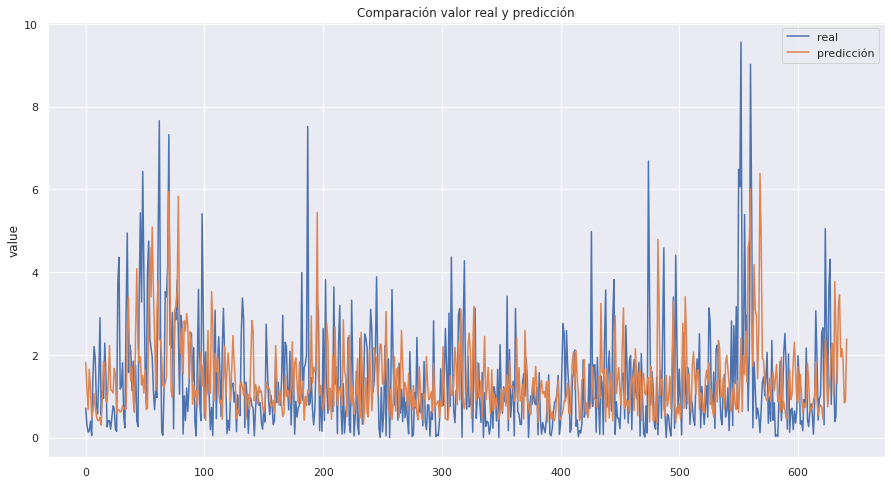

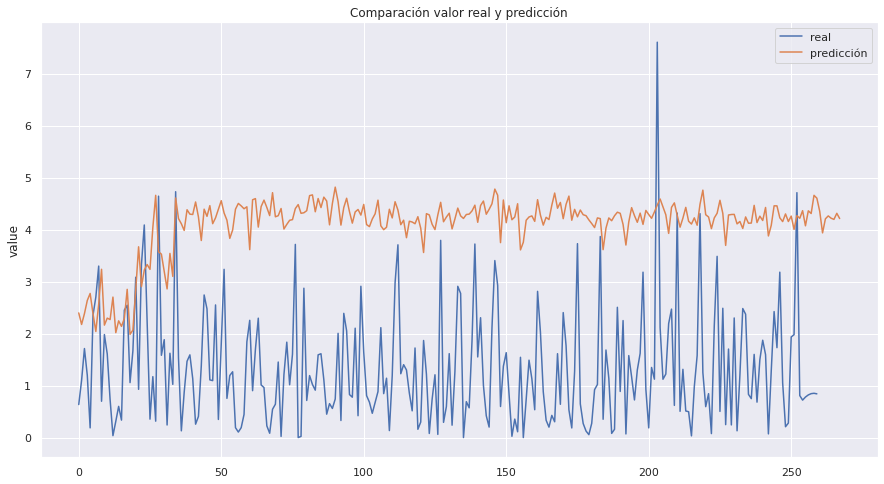

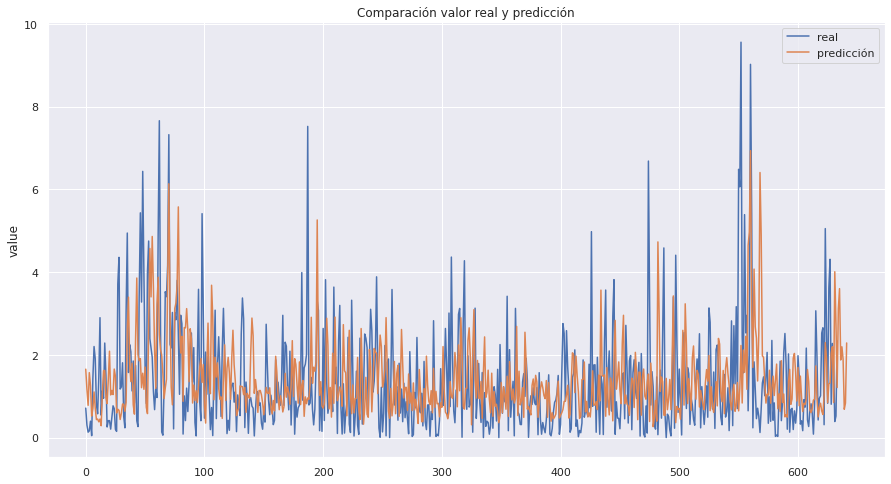

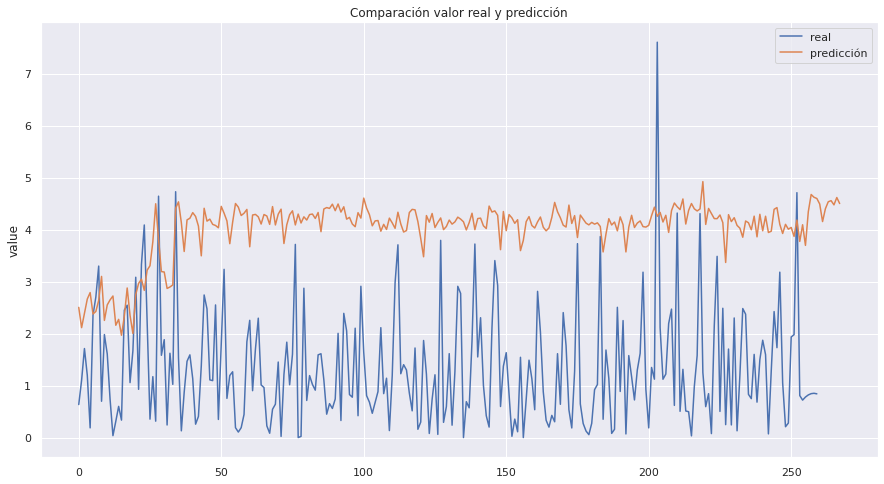

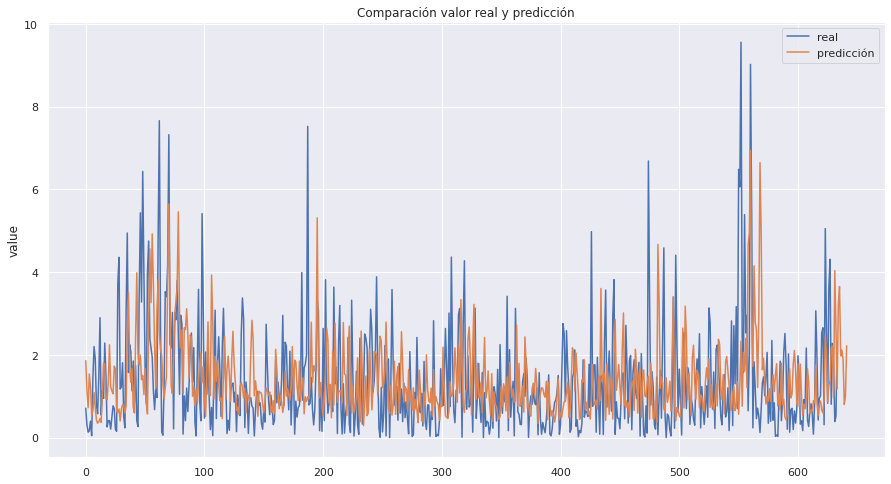

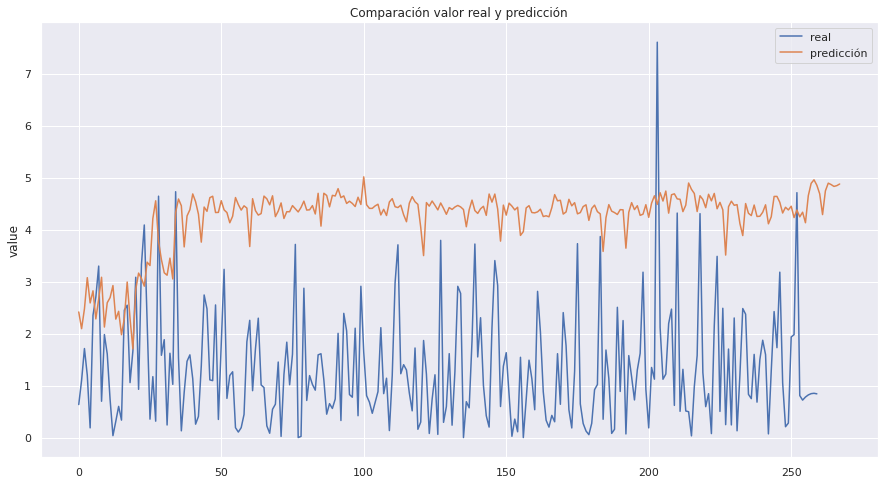

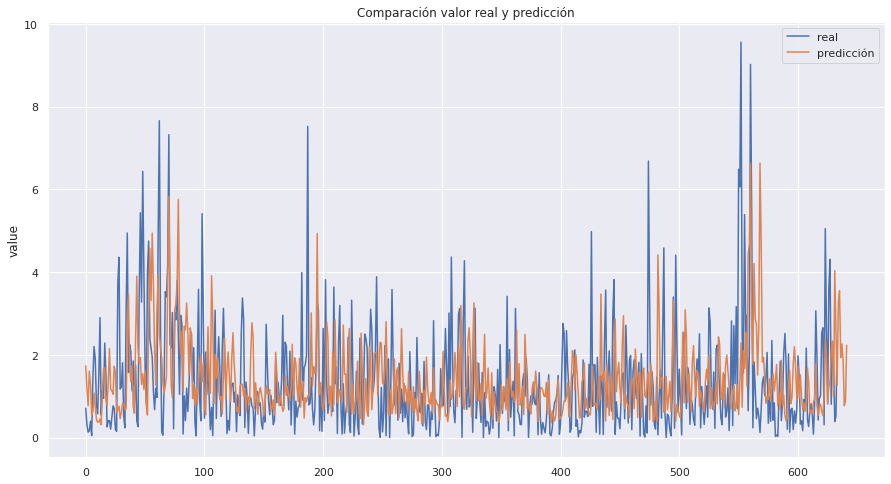

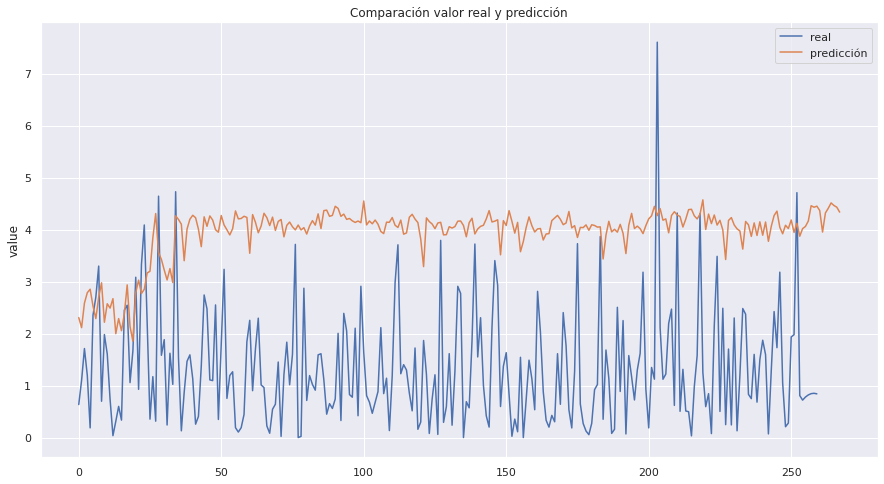

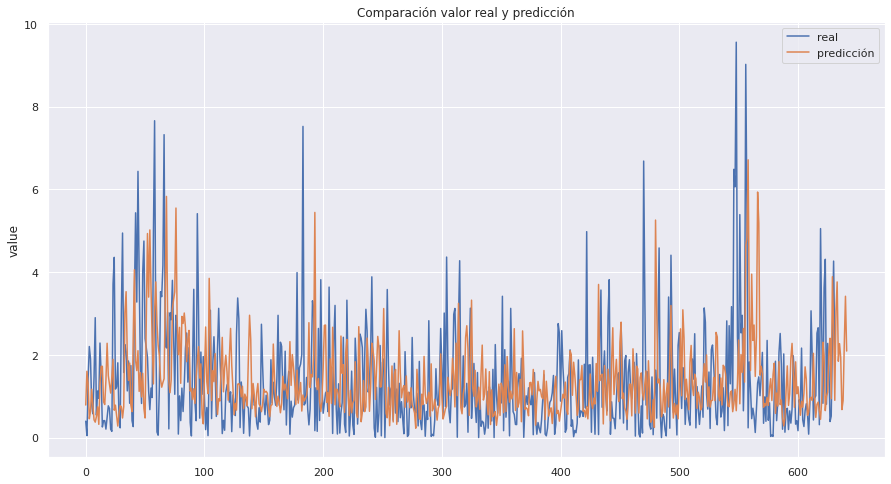

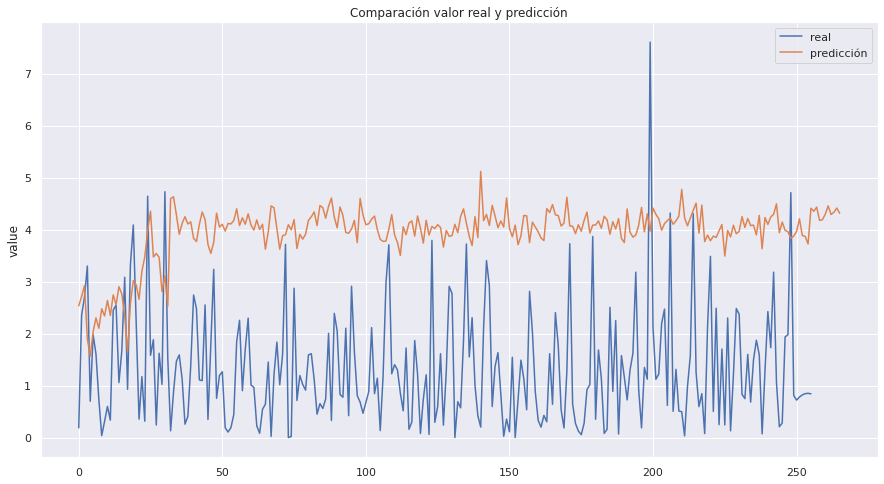

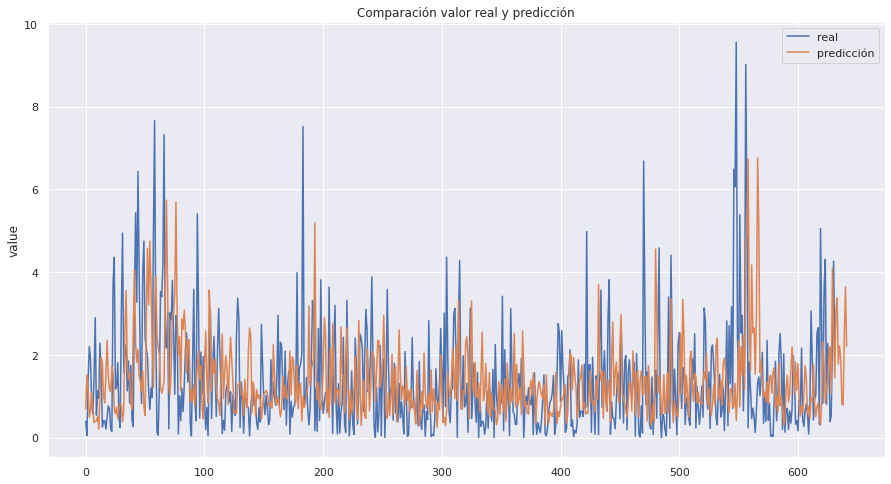

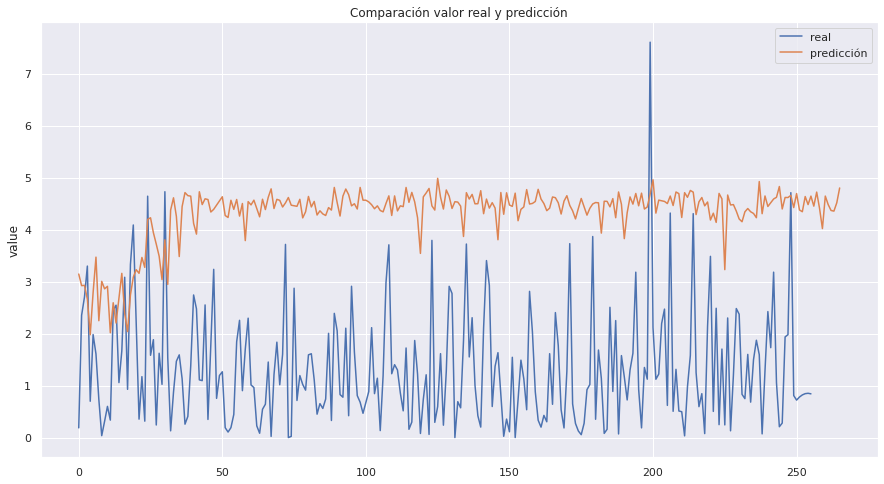

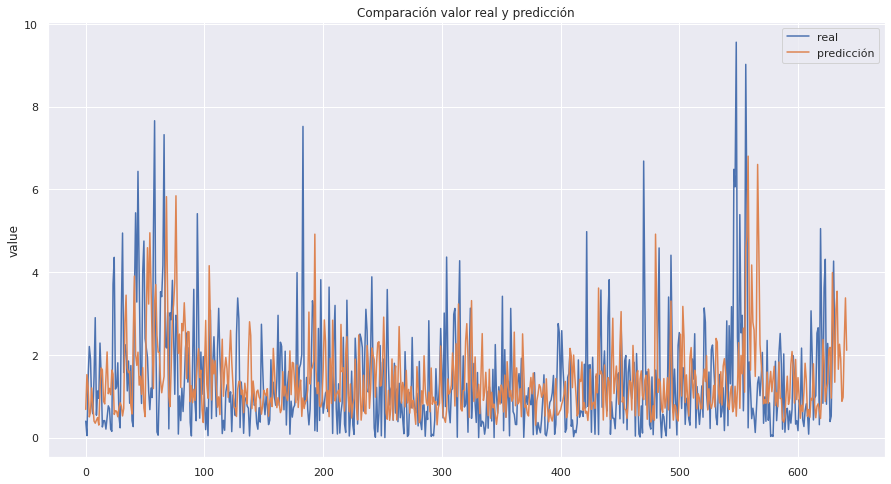

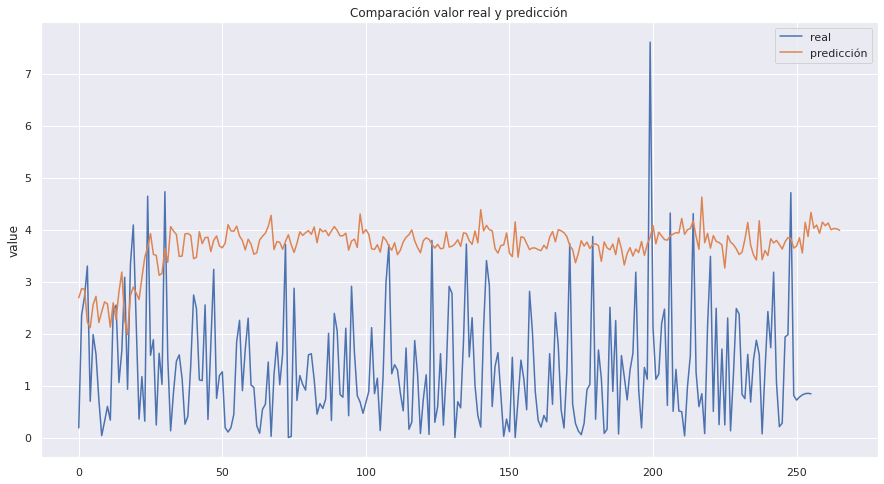

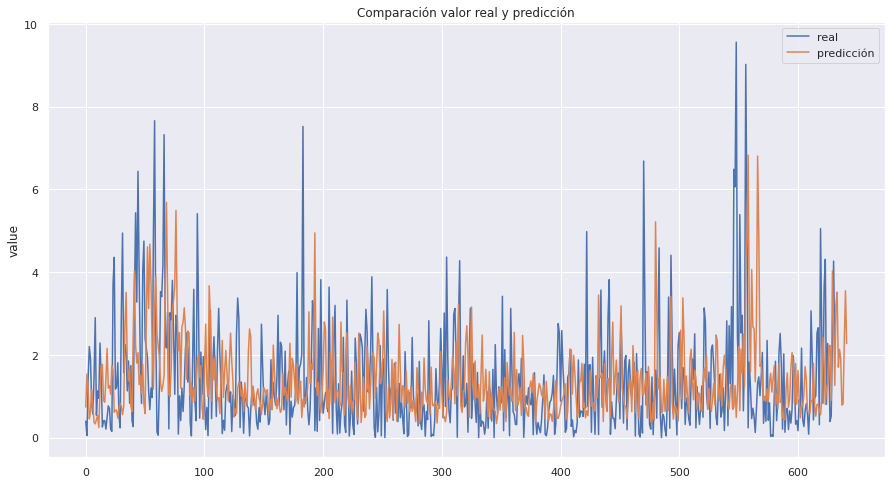

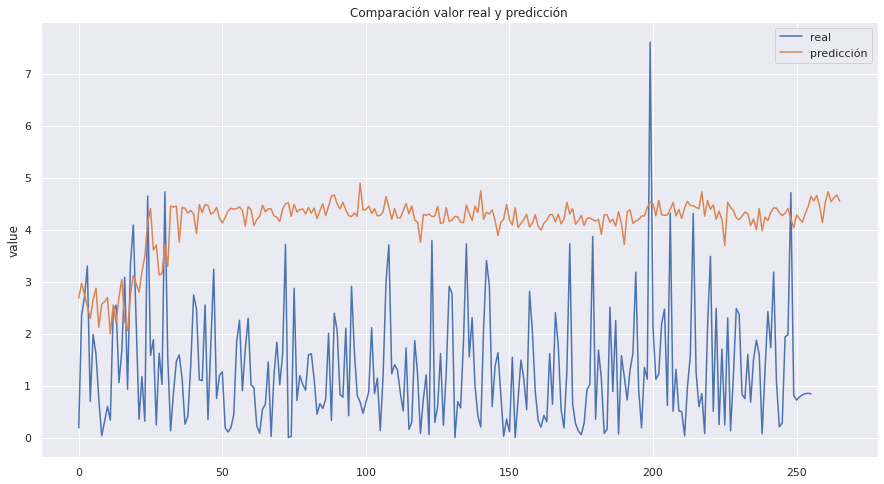

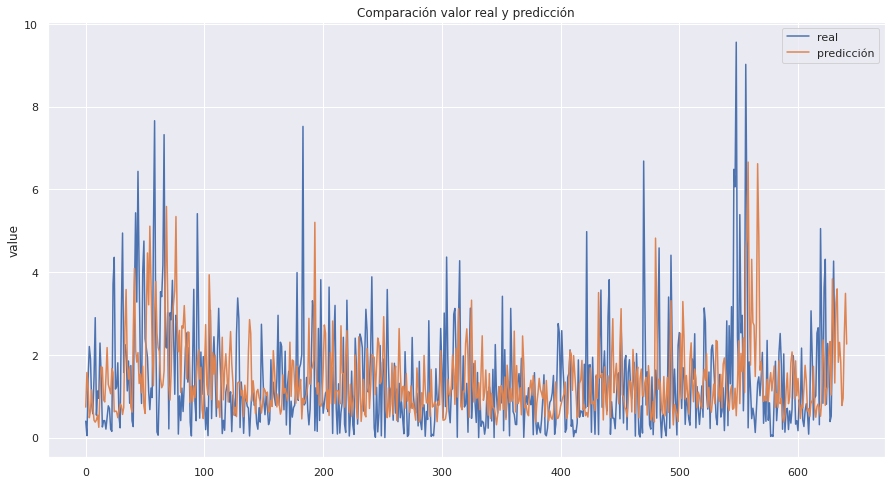

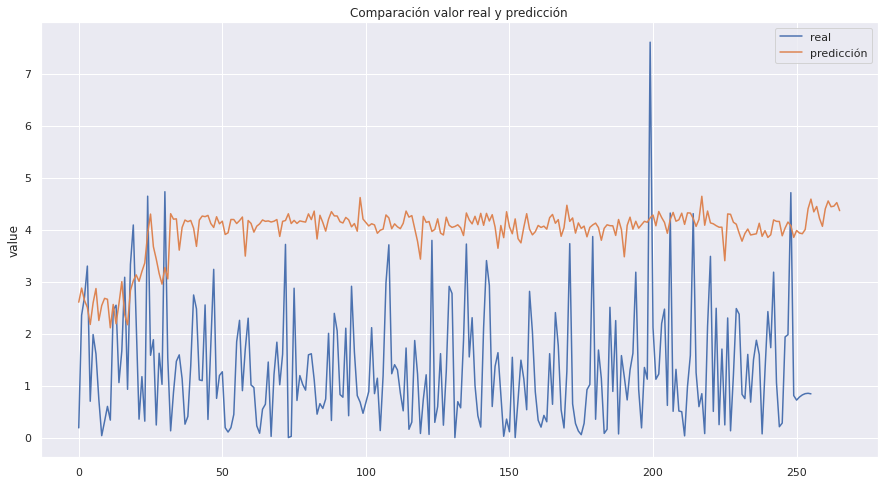

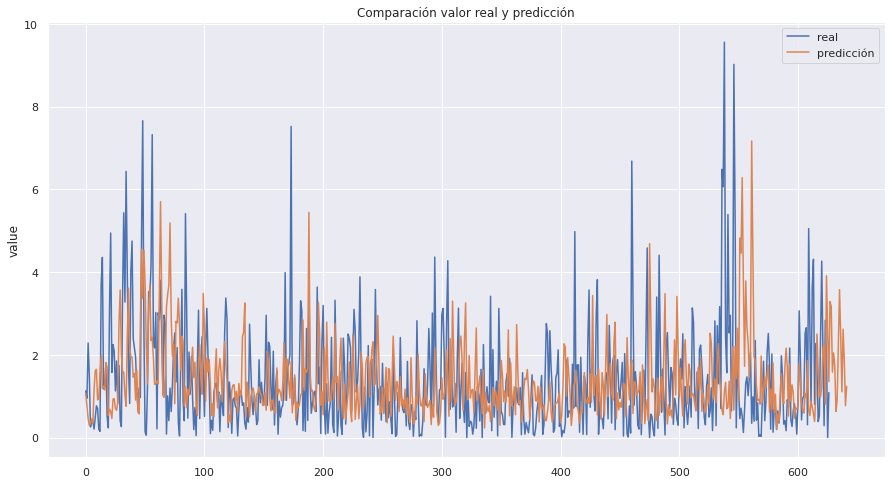

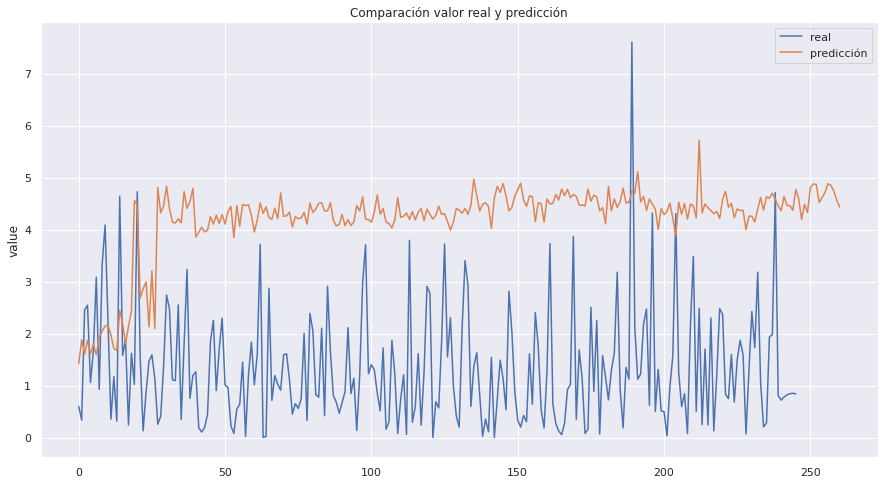

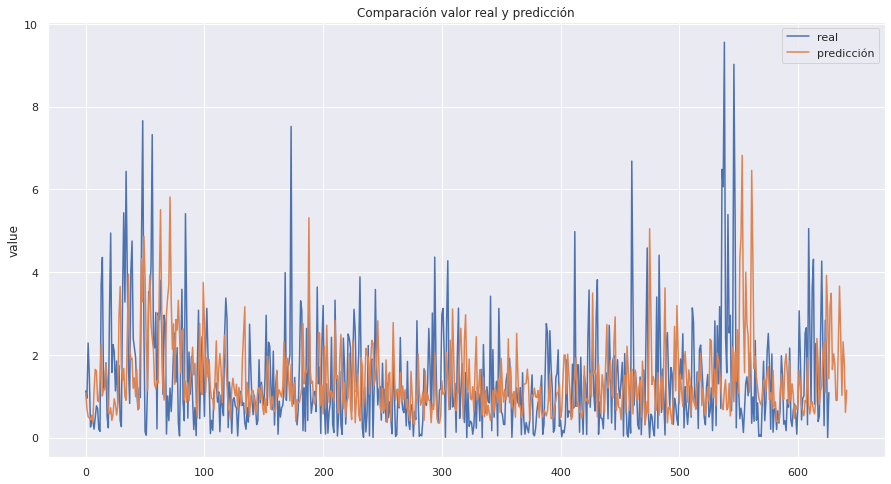

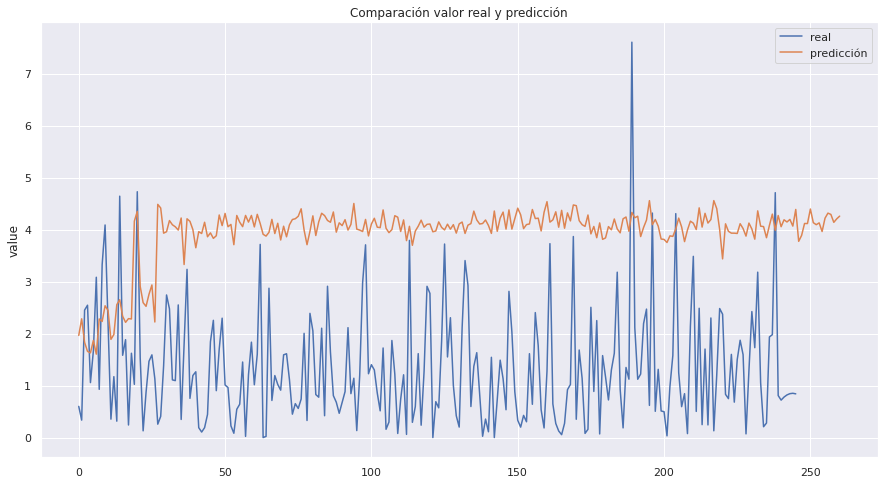

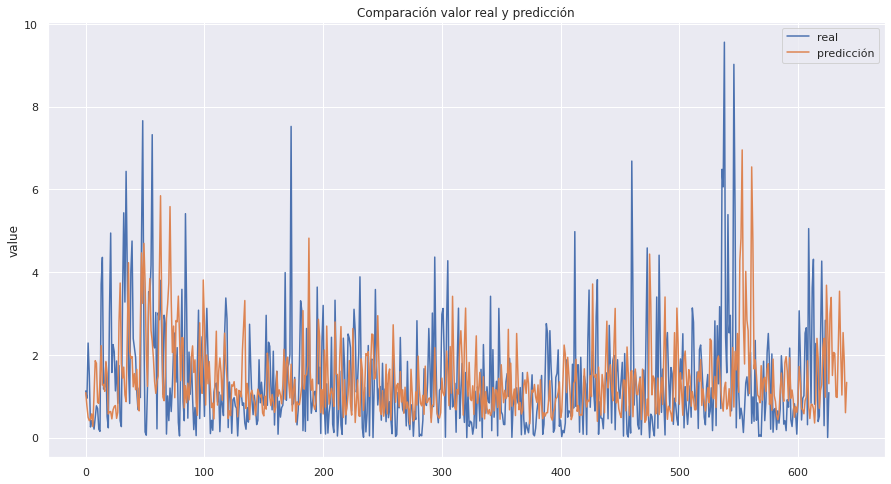

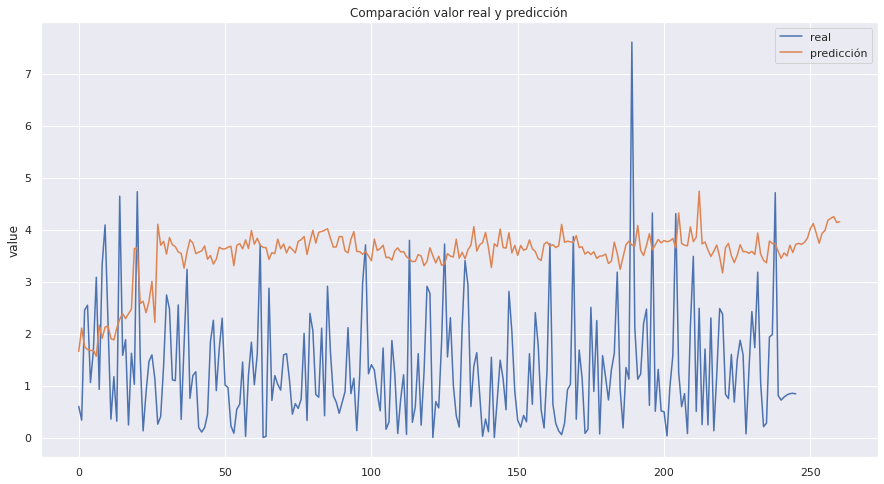

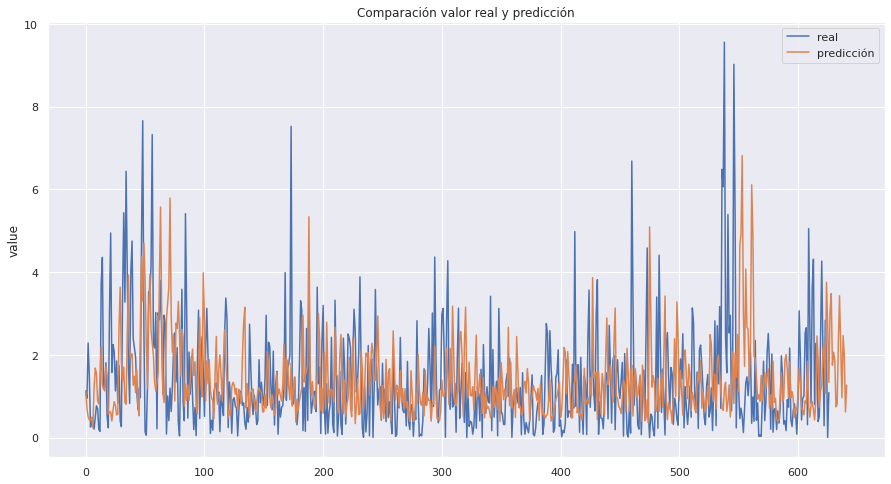

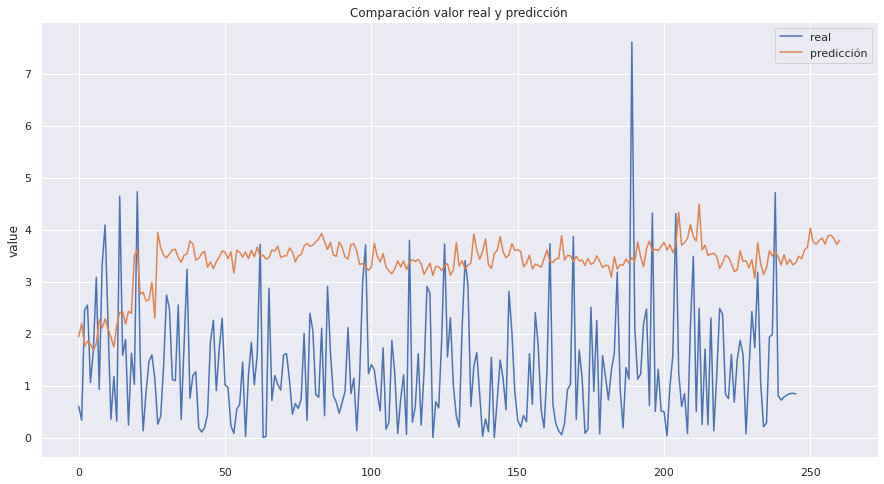

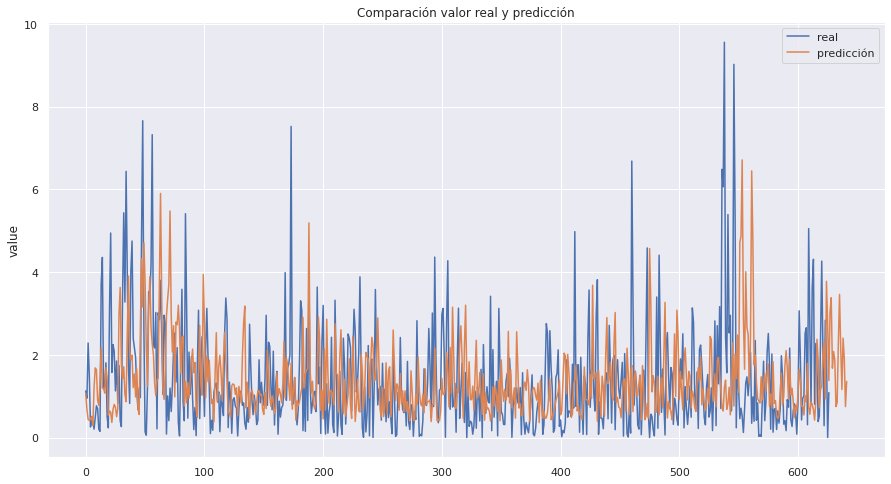

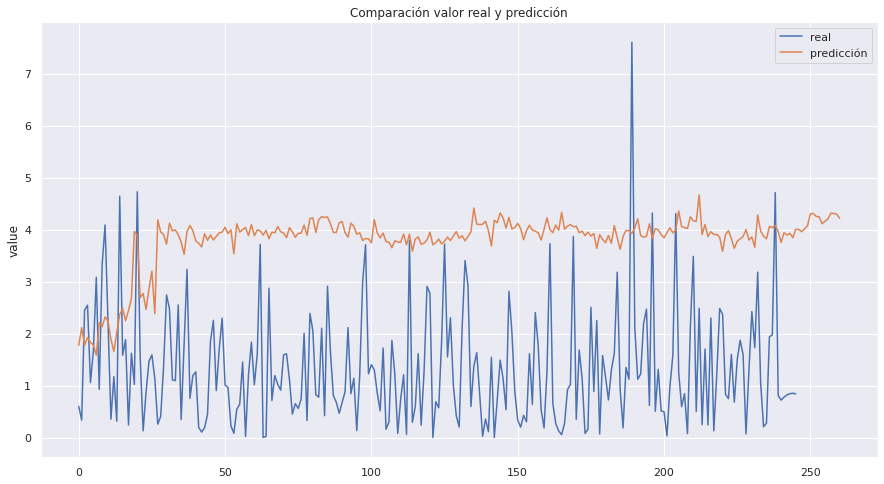

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)